# **Geological facies connectivity and upscaling in reservoir simulation for production forecasts optimization**
## __Results__

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import StrMethodFormatter

conDir = ['./2d/2dcon_128/', './2d/2dint_128/', './2d/2ddis_128/']
varDir = ['0.5/', '1/', '2/']
stCon = ['HCS', 'ICS', 'LCS']

nseeds = 128
lc = 16
con = [2, 1, 3]
varSim = [0.5, 1, 2] 
scales = np.array([1,2,4,8,16,32,64,128,256,512,1024]) 
scaleAtt = np.linspace(1,512,1000)

linestyle = ['dashed', 'dotted', 'dashdot']
marker = ['^', 'o', 's', '^']
color = ['red', 'darkgreen', 'navy']
color_grey = ['grey', 'dimgrey', 'black']

## __Fine grid values calculation__
<ul>
<li>Arithmetic mean</li>
<li>Geometric mean</li>
<li>Variance</li>
</ul>

In [6]:
### Fine grid values calculations ###
k_FG = np.array([])
kg_FG = np.array([])
var_FG = np.array([])
for icon in range(len(conDir)):
    rdir1 = conDir[icon]
    k = np.array([])
    kg = np.array([])
    var = np.array([])
    for ivar in range(len(varDir)):
        rdir2 = varDir[ivar]
        k1 = np.array([])
        kg1 = np.array([])
        var1 = np.array([])
        for iseed in range(nseeds):
            aux = np.load(rdir1+rdir2+str(iseed)+'/k.npy').reshape(-1)
            k1 = np.append(k1, np.mean(aux))
            kg1 = np.append(kg1, np.exp(np.mean(np.log(aux))))
            var1 = np.append(var1, np.var(np.log(aux)))
            #print(k1, k1.shape)
        k = np.append(k, np.mean(k1))
        kg = np.append(kg, np.mean(kg1))
        var = np.append(var, np.mean(var1))
    k_FG = np.append(k_FG, k)
    kg_FG = np.append(kg_FG, kg)
    var_FG = np.append(var_FG, var)
k_FG = np.reshape(k_FG, (len(conDir),len(varDir)))
kg_FG = np.reshape(kg_FG, (len(conDir),len(varDir)))
var_FG = np.reshape(var_FG, (len(conDir),len(varDir)))
print(k_FG, k_FG.shape)
print(kg_FG, kg_FG.shape)
print(var_FG, var_FG.shape)

[[1.2880463  1.65537744 2.73200151]
 [1.28385046 1.64801092 2.71694494]
 [1.27902685 1.64004753 2.70088972]] (3, 3)
[[1.00380587 1.00542227 1.00774853]
 [1.00076527 1.00111312 1.00163601]
 [0.99632895 0.99484739 0.99279083]] (3, 3)
[[0.49894809 0.99789619 1.99579238]
 [0.49783791 0.99567581 1.99135162]
 [0.49894809 0.99789619 1.99579238]] (3, 3)


## __Analytical functions definition__
### From Eberhard et al., 2006.

#### a. Equivalent hydraulic conductivity as a function of coarsening scale
$$ \ \left \langle K_{eq} \right \rangle  \left ( \lambda \right ) = \left \langle Y \right \rangle exp\left \{ -\frac{\sigma _{Y}^{2}}{D}+\frac{\sigma _{Y}^{2}}{D} \left [erf\left ( \frac{Ia_{s}}{\sqrt{2}\lambda } \right )  \right ]^{D}  \right \} $$

#### b. Variance of log of equivalent hydraulic conductivity as a function of coarsening scale
$$ \ \sigma_{log\left ( K_{eq} \right )}^{2}  \left ( \lambda \right ) =  K_{g}^{2} + \sigma _{Y}^{2} \left [erf\left ( \frac{Ia_{s}}{\sqrt{2}\lambda } \right )  \right ]^{D}  $$

In [5]:
### Analytical functions ###

#a
def attinger_amean(variance, scale, a, lc, Kg): 
    keff_scale = Kg * np.exp((variance/2)*(erf((lc*a)/(np.sqrt(2)*scale)))**2)
    return keff_scale

#b
def attinger_var(variance, scale, a, lc, Kg): #Attinger (Eq. 3.2.3, Boschan & Noetinger 2012)
    var_scale = Kg**2 * variance * (erf ((lc*a)/(np.sqrt(2)*scale)))**2
    return var_scale

## __Geometric mean as a function of &lambda;/I__

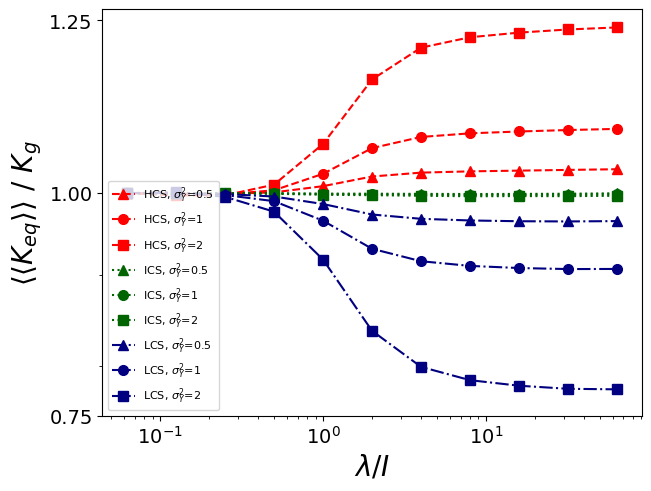

In [6]:
### Geometric mean ###

fig, ax = plt.subplots(1,1,layout="constrained")
# fig.set_figwidth(5)
# fig.set_figheight(5)
for icon in range(len(conDir)):
    rdir1=conDir[icon]
    for ivar in range(len(varDir)):
        rdir2=varDir[ivar]
        keff = np.zeros(len(scales))
        for iscale in range(len(scales)):
            scale = scales[iscale]
            aux = np.array([])
            for iseed in range(nseeds):
                if scale == scales[0]:
                    aux = kg_FG[icon][ivar]
                elif scale == scales[-1]:
                    aux = np.append(aux, np.loadtxt(rdir1+rdir2+str(iseed)+'/SolverRes.txt')[0])
                else:
                    try:
                        aux = np.append(aux, np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scale)+'.npy').reshape(-1))
                    except:
                        pass
            keff[iscale] = np.exp(np.mean(np.log(aux)))
        ax.loglog(scales/lc, keff/kg_FG[icon][ivar], label=stCon[icon]+', '+r'$\sigma^2_{Y}$'+'='+str(varSim[ivar]), color=color[icon], 
                  marker=marker[ivar], markersize=7, fillstyle='full', linewidth=1.5, linestyle=linestyle[icon])
        ax.set_xlabel(r'$\lambda / I$', fontsize=20)
        ax.set_ylabel(r'$⟨⟨K_{eq}⟩⟩ \ / \ K_{g}$', fontsize=20)
        ax.get_yaxis().set_major_formatter(ScalarFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.set_yticks(ticks=np.arange(0.75,1.5,0.25), labels=np.arange(0.75,1.5,0.25))
        ax.tick_params(axis='both', labelsize=14)
        ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        ax.legend(loc='lower left', fontsize=8, ncol=1)
plt.show()
plt.close()
#plt.savefig('2D_geoMean_allVar.png', format='png', dpi=300, bbox_inches='tight', )


/tmp/ipykernel_43601/2404570729.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 0.85, 1])


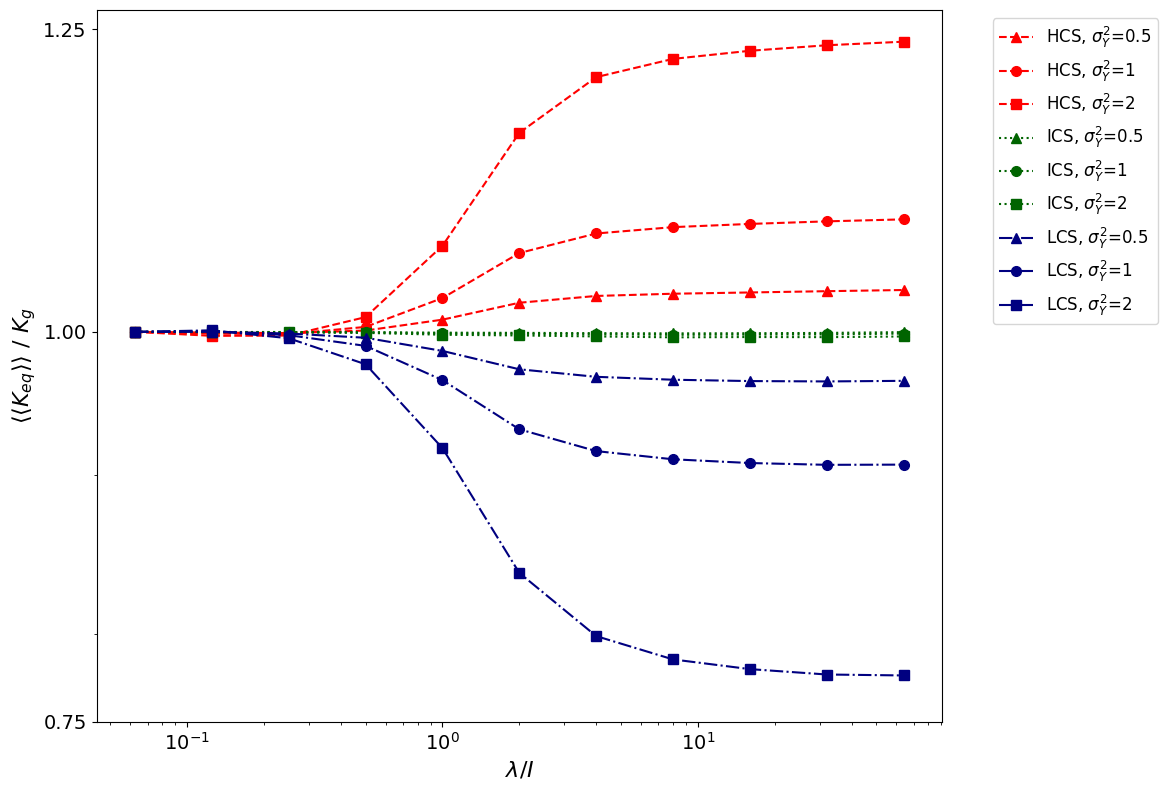

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter, NullFormatter
import warnings

fig, ax = plt.subplots(figsize=(14, 8), layout="constrained")

for icon, rdir1 in enumerate(conDir):
    for ivar, rdir2 in enumerate(varDir):
        keff = np.zeros(len(scales))
        for iscale, scale in enumerate(scales):
            aux = []
            for iseed in range(nseeds):
                file_path = f"{rdir1}{rdir2}{iseed}/"
                if scale == scales[0]:
                    aux.append(kg_FG[icon][ivar])
                elif scale == scales[-1]:
                    try:
                        aux.append(np.loadtxt(file_path + "SolverRes.txt")[0])
                    except Exception as e:
                        warnings.warn(f"Error reading {file_path}SolverRes.txt: {e}")
                else:
                    try:
                        aux.append(np.load(file_path + f"KpostProcess/Kperm{scale}.npy").reshape(-1))
                    except Exception as e:
                        warnings.warn(f"Error loading {file_path}KpostProcess/Kperm{scale}.npy: {e}")

            if aux:
                aux = np.concatenate(aux) if isinstance(aux[0], np.ndarray) else np.array(aux)
                keff[iscale] = np.exp(np.mean(np.log(aux)))

        ax.loglog(
            scales / lc, keff / kg_FG[icon][ivar], 
            label=f"{stCon[icon]}, " + r"$\sigma^2_{Y}$" + f"={varSim[ivar]}",
            color=color[icon], marker=marker[ivar], markersize=7, 
            fillstyle='full', linewidth=1.5, linestyle=linestyle[icon]
        )

ax.set_xlabel(r'$\lambda / I$', fontsize=16)
ax.set_ylabel(r'$⟨⟨K_{eq}⟩⟩ \ / \ K_{g}$', fontsize=16)
ax.get_yaxis().set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())
ax.set_yticks(ticks=np.arange(0.75, 1.5, 0.25), labels=np.arange(0.75, 1.5, 0.25))
ax.tick_params(axis='both', labelsize=14)
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.2f}'))

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12, ncol=1)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


__Fig. 4__: ⟨⟨Keq⟩⟩ / Kg as a function of $\lambda$ / l for HCS, ICS and LCS in 2D. Input variance: (△) $\sigma$(Y)=0.5, (〇) $\sigma$(Y)=1 and (◻) $\sigma$(Y)=2. 

## __Arithmetic mean as a function of &lambda;/I__

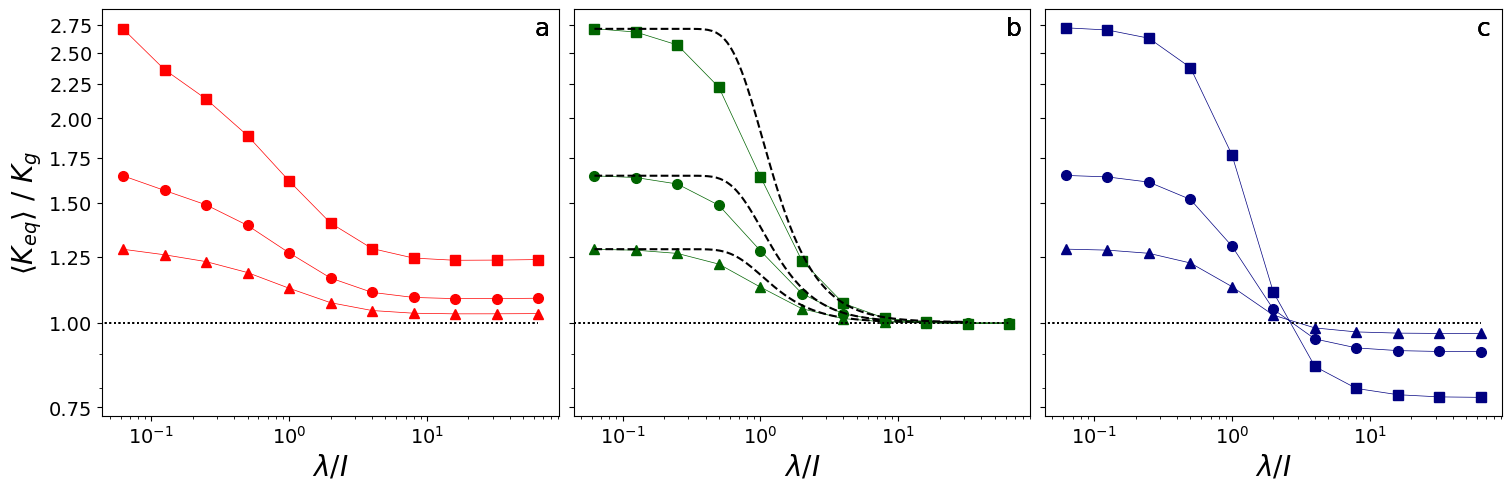

In [9]:
### Arithmetic mean for paper plots ###
num=['a','b','c']

fig, ax = plt.subplots(1,3,layout="constrained", sharey=True)
fig.set_figwidth(15)

def attinger_amean(variance, scale, a, lc, Kg): 
    keff_scale = Kg * np.exp((variance/2)*(erf((lc*a)/(np.sqrt(2)*scale)))**2)
    return keff_scale

for icon in range(len(conDir)):
    rdir1=conDir[icon]
    for ivar in range(len(varDir)):
        rdir2=varDir[ivar]
        keff = np.zeros(len(scales))
        for iscale in range(len(scales)):
            scale = scales[iscale]
            aux = np.array([])
            for iseed in range(nseeds):
                if scale == scales[0]:
                    aux = k_FG[icon][ivar]
                elif scale == scales[-1]:
                    aux = np.append(aux, np.loadtxt(rdir1+rdir2+str(iseed)+'/SolverRes.txt')[0])
                else:
                    try:
                        aux = np.append(aux, np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scale)+'.npy').reshape(-1))
                    except:
                        pass
            keff[iscale] = np.nanmean(aux)
        ax[icon].loglog(scales/lc, keff/kg_FG[icon][ivar], label=r'$\sigma^2_{Y}$'+' = '+str(varSim[ivar]), color=color[icon], 
            marker=marker[ivar], markersize=7, fillstyle='full', linewidth=.5, linestyle='-')
        if icon == 1:
            ax[icon].loglog(scaleAtt/lc, attinger_amean(var_FG[icon][ivar], scaleAtt, 1.3, lc, kg_FG[icon][ivar]), 
                label='Analitycal'+': '+r'$\sigma^2_{Y}$'+' = '+str(varSim[ivar]), color='black', linewidth=1.5, linestyle='--')
        ax[icon].set_xlabel(r'$\lambda / I$',fontsize=20)
        ax[0].set_ylabel(r'$⟨K_{eq}⟩ \ / \ K_{g}$', fontsize=20)
        ax[icon].get_yaxis().set_major_formatter(ScalarFormatter())
        ax[icon].yaxis.set_minor_formatter(NullFormatter())
        ax[icon].set_yticks(ticks=np.arange(0.75,3,0.25), labels=np.arange(0.75,3,0.25))
        ax[0].get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        ax[icon].hlines(1, 0, 64,linestyle=':', color='black', linewidth=1.25)
        ax[icon].tick_params(axis='both', labelsize=14)
        ax[icon].text(60, 2.65, num[icon], style='normal', fontsize=18)
        #ax[icon].set_title(num[icon], fontsize=18, loc='left', weight='bold')
        #ax[icon].set_title(stCon[icon], fontsize=16, loc='center')
        # ax[0].set_yticks(ticks=np.arange(1,3,0.25), labels=np.arange(1,3,0.25))
        # ax[1].set_yticks(ticks=np.arange(1,3,0.25), labels=np.arange(1,3,0.25))
        # ax[2].set_yticks(ticks=np.arange(0.75,3,0.25), labels=np.arange(0.75,3,0.25))
        # ax[1].tick_params(left=False)
        # ax[2].tick_params(left=False)
#fig.savefig('2D_arMean.png', format='png', dpi=300, bbox_inches='tight')

__Fig. 5__: 2D ⟨Keq⟩ / Kg as a function of $\lambda$ / l for (a) HCS, (b) ICS and (c) LCS. Input variances: (△) $\sigma$(Y)=0.5, (⭘) $\sigma$(Y)=1 and (◻) $\sigma$(Y)=2. (---) (b): analytical prediction given by Eberhard et al., 2006 using D=2 and as=1.3.

## __Probability density functions (PDF)__

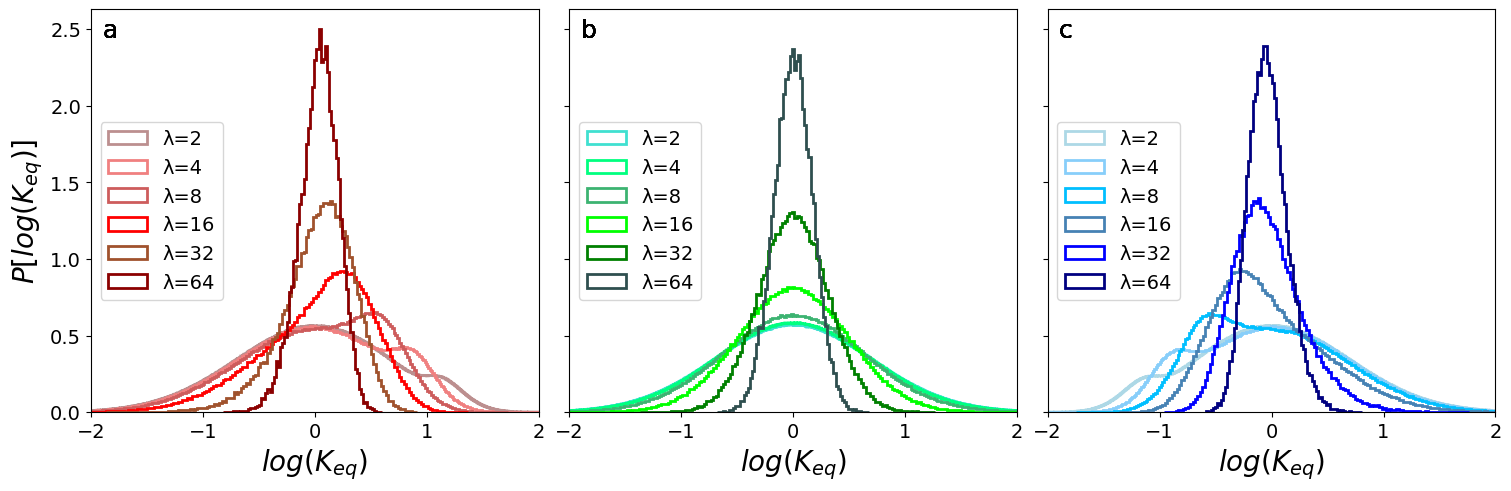

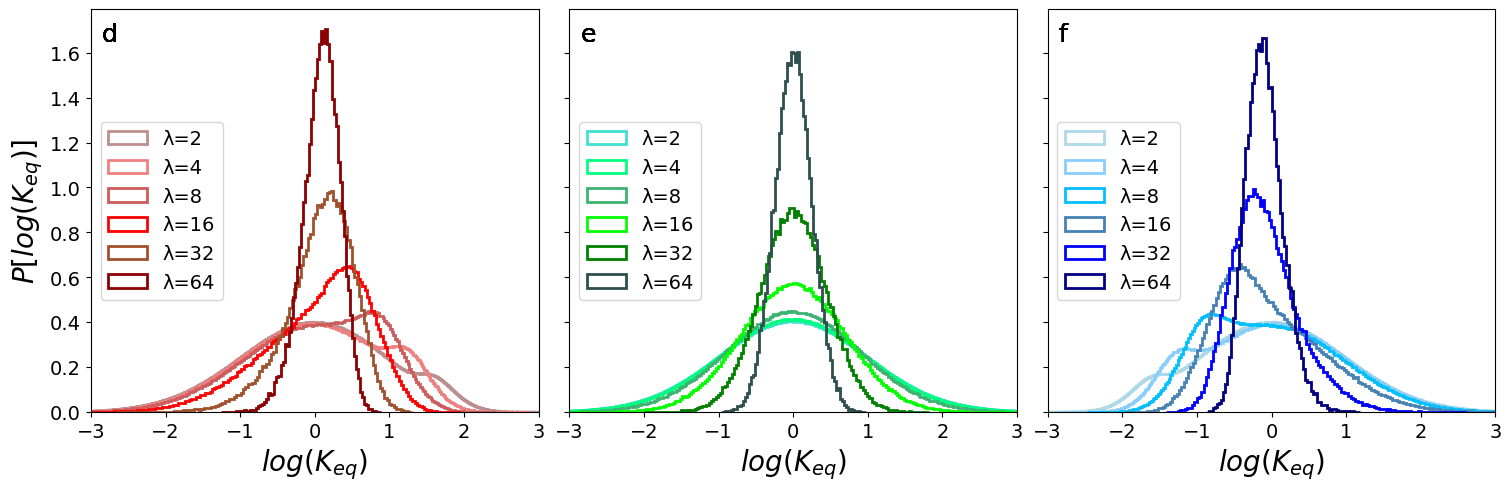

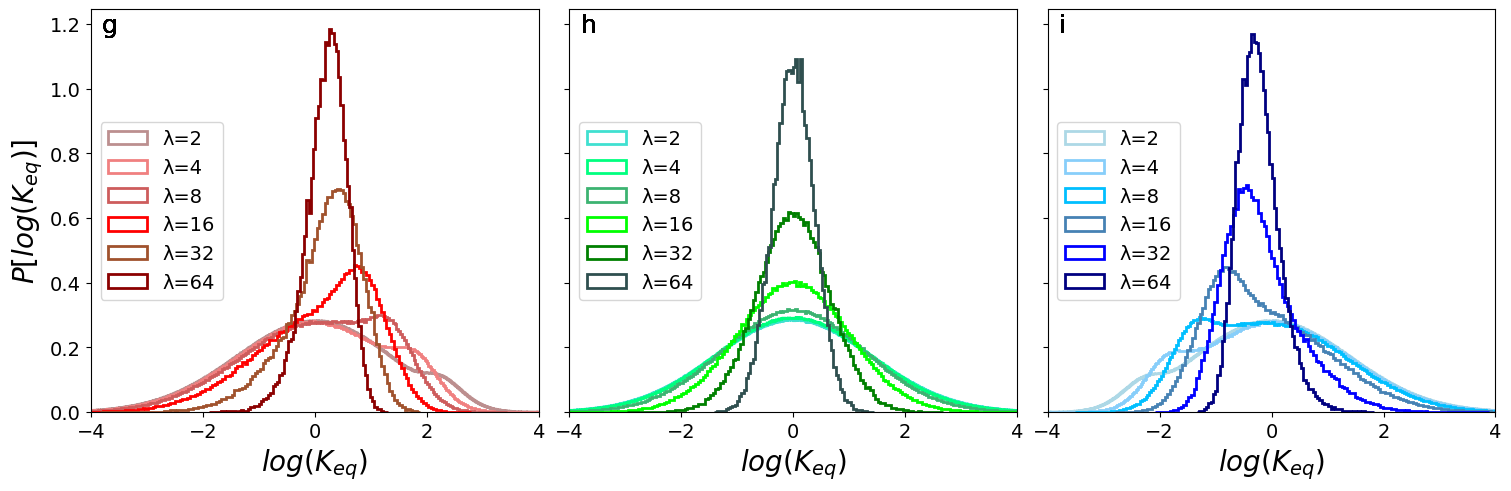

In [11]:
### Probability density function ####

from matplotlib.offsetbox import AnchoredText

scale_col = [["rosybrown","lightcoral","indianred","red","sienna","darkred"], 
             ["turquoise", "springgreen", "mediumseagreen", "lime", "green", "darkslategrey"],
             ["lightblue", "lightskyblue", "deepskyblue", "steelblue", "blue", "navy"]]
# scale_col_green = [
# scale_col_blue = [

scalesHist = [2,4,8,16,32,64]
xTheo = np.linspace(-3, 3, 500)

conDir = ['./2d_1024L_128r/2dcon_128/', './2d_1024L_128r/2dint_128/', './2d_1024L_128r/2ddis_128/']
stCon = ['HCS', 'ICS', 'LCS']
varDir = ['0.5/','1/','2/']
varSim = [0.5, 1, 2]

num = [['a','b','c'],['d','e','f'],['g','h','i']]

#ylim = ([0,2.75], [0,2.75], [0,2.75])
xlim = ([-2,2], [-3,3], [-4,4])
xy = [(-1.5,2.3), (-1.5, 2.0), (-1.5, 1.7), (-1.5, 1.4), (-1.5, 1.1)]
xnum = [-1.9, -2.85, -3.8]
ynum = [2.45, 1.65, 1.175]
for ivar in range(len(varDir)):
    fig, ax = plt.subplots(1, 3, sharey=True, layout='constrained')
    fig.set_figwidth(15)
    rdir2 = varDir[ivar]
    for icon in range(len(conDir)):
        rdir1 = conDir[icon]
        for iscale in range(len(scalesHist)):
            scale = scalesHist[iscale]
            keff = np.array([])
            for iseed in range(nseeds):
                if scale == 1:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/k.npy').reshape(-1)
                    keff = np.append(keff, aux)
                else:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scale)+'.npy').reshape(-1)
                    aux = aux[aux>0]
                    aux = aux[~np.isnan(aux)]
                    keff = np.append(keff, aux)
                
            ax[icon].hist(np.log(keff), bins='scott', density=True, histtype='step', label='\u03BB'+'='+str(scale), linewidth=2, 
                color=scale_col[icon][iscale])
            
            ax[icon].set_xlabel(r'$log(K_{eq})$', fontsize=20)
            ax[0].set_ylabel(r'$P[log(K_{eq})]$', fontsize=20)
            ax[icon].tick_params(axis='both', labelsize=14)
            ax[icon].set_xlim(xlim[ivar])
            # ax[icon].set_ylim(0,2.75)
            ax[icon].legend(fontsize=14, frameon=True, loc='center left')
            ax[icon].text(xnum[ivar], ynum[ivar], num[ivar][icon], style='normal', fontsize=18)
           
            #ax[icon].text(-1.9, 2.45, num[1][icon], style='normal', fontsize=18)
            #ax[0].annotate('\u03BB'+'='+str(64), xy=(0.15,1.9), xytext=(1.25,2), arrowprops=dict(arrowstyle="->", facecolor='black'), fontsize=15)
            #ax[0].annotate('\u03BB'+'='+str(2), xy=(1.3,0.15), xytext=(1.5,0.75), arrowprops=dict(arrowstyle="->", facecolor='black'), fontsize=15)                                          
            #plt.legend(fontsize=12, frameon=True, loc='best', ncol=3)
            #ax[icon].set_title(num[ivar][icon], fontsize=18, loc='left', weight='bold')
            #ax[icon].set_title(stCon[icon]+', '+r"$\sigma^2_{Y}$"+' = '+str(varSim[ivar]), fontsize=16, loc='center')
            #ax[0].text(0.25, 2, '\u03BB'+'='+str(scalesHist[4]))
            #ax[icon].set_ylim(0,2.6)
            #ax[icon].set_yscale('log')
            #ax[ivar].tick_params(axis='both', labelsize=fontsize)
            #fig.savefig('2D_PDF_'+stCon[icon] +'.png', format='png', dpi=300, bbox_inches='tight')
            #plt.savefig('2D_skew_128.png', format='png', dpi=300, bbox_inches='tight')->", facecolor='black'), fontsize=15)
            

__Fig. 6__: 2D probability density function P[log(Keq)] for the (a, d, g) high, (b, e, h) intermediate and (c, f, i) low connectivity structures. Input variance (a, b, c) $\sigma$(Y)=0.5, (d, e, f) $\sigma$(Y)=1 and (g, h, i) $\sigma$(Y)=2.

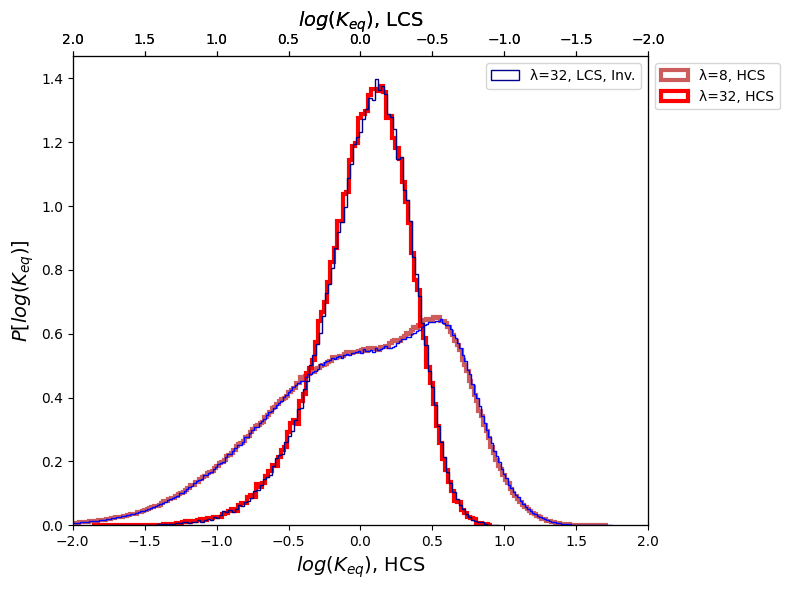

In [13]:
### Comparison of 2D HCS and LCS PDF reflections ####

scale_col_HCS = ["indianred","red"]
scale_col_LCS = ["blue","darkblue"]

scalesHist = [8, 32]
xTheo = np.linspace(-3, 3, 500)

conDir = ['./2d/2dcon_128/']#, './2d_1024L_128r/2ddis_128/']
stCon = ['HCS', 'LCS']
varDir = ['0.5/']
varSim = [0.5]
for ivar in range(len(varDir)):
    rdir2 = varDir[ivar]
    fig, ax1 = plt.subplots(figsize=(8,6))
    for icon in range(len(conDir)):
        rdir1 = conDir[icon]
        for iscale in range(len(scalesHist)):
            scale = scalesHist[iscale]
            keff = np.array([])
            for iseed in range(nseeds):
                if scale == 1:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/k.npy').reshape(-1)
                    keff = np.append(keff, aux)
                else:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scale)+'.npy').reshape(-1)
                    aux = aux[aux>0]
                    aux = aux[~np.isnan(aux)]
                    keff = np.append(keff, aux)
            ax1.hist(np.log(keff), bins='scott', density=True, histtype='step', label='\u03BB'+'='+str(scale)+', '+stCon[0], linewidth=3, 
                color=scale_col_HCS[iscale])
            ax1.set_xlim(-2,2)
            ax1.set_xlabel(r'$log(K_{eq})$'+', '+'HCS', fontsize=14)
            ax1.set_ylabel(r'$P[log(K_{eq})]$', fontsize=14)
     

    
conDir = ['./2d/2ddis_128/']
stCon = ['LCS']
for ivar in range(len(varDir)):
    rdir2 = varDir[ivar]
    #fig, ax1 = plt.subplots(figsize=(8,6))
    for icon in range(len(conDir)):
        rdir1 = conDir[icon]
        for iscale in range(len(scalesHist)):
            scale = scalesHist[iscale]
            keff = np.array([])
            for iseed in range(nseeds):
                if scale == 1:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/k.npy').reshape(-1)
                    keff = np.append(keff, aux)
                else:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scale)+'.npy').reshape(-1)
                    aux = aux[aux>0]
                    aux = aux[~np.isnan(aux)]
                    keff = np.append(keff, aux)
                    
            ax2 = ax1.twiny()
            ax2.hist(np.log(keff), bins='scott', density=True, histtype='step', label='\u03BB'+'='+str(scale)+', '+stCon[0]+', '+'Inv.', linewidth=1, 
                color=scale_col_LCS[iscale])
            ax2.set_xlim(-2,2)
            ax2.invert_xaxis()
            ax2.set_xlabel(r'$log(K_{eq})$'+', '+'LCS', fontsize=14)
        
        # Adjust legends to prevent overlap
        ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))
        
        # Set main axis labels and limits
        ax1.set_xlim(-2, 2)
        ax1.set_xlabel(r'$log(K_{eq})$' + ', HCS', fontsize=14)
        ax1.set_ylabel(r'$P[log(K_{eq})]$', fontsize=14)
        
        plt.tight_layout()
        plt.show()

        
            #plt.savefig('2D_hist_inv_esc 16.png', format='png', dpi=300, bbox_inches='tight')
            
    
 
                    

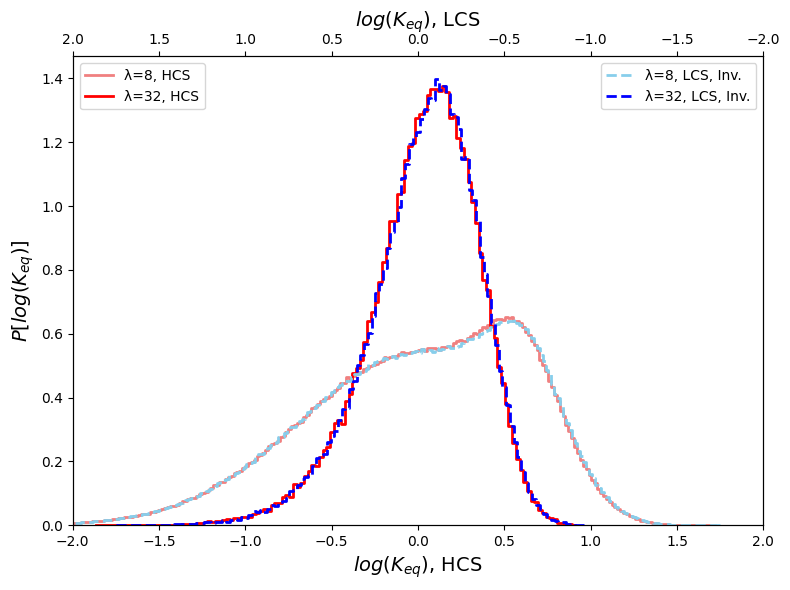

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

scale_col_HCS = ['lightcoral', 'red'] 
scale_col_LCS = ['skyblue', 'blue'] 

scalesHist = [8, 32]
xTheo = np.linspace(-3, 3, 500)
nseeds = 128
varDir = ['0.5/']
varSim = [0.5]

conDirs = [['./2d/2dcon_128/', 'HCS', scale_col_HCS], ['./2d/2ddis_128/', 'LCS', scale_col_LCS]]

for ivar, rdir2 in enumerate(varDir):
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax2 = ax1.twiny()
    for rdir1, stCon, scale_colors in conDirs:
        for scale, color in zip(scalesHist, scale_colors):
            keff = []
            for iseed in range(nseeds):
                file_path = f"{rdir1}{rdir2}{iseed}/"
                if scale == 1:
                    aux = np.load(file_path + 'k.npy').reshape(-1)
                else:
                    aux = np.load(file_path + f'KpostProcess/Kperm{scale}.npy').reshape(-1)
                    aux = aux[aux > 0]
                    aux = aux[~np.isnan(aux)]
                keff.extend(aux)

            log_keff = np.log(keff)
            if stCon == 'HCS':
                sns.histplot(log_keff, bins='scott', fill=False, alpha=1, kde=False, stat="density", linestyle='-',
                             element="step", label=f'\u03BB={scale}, {stCon}', linewidth=2, color=color, ax=ax1)
            else:
                sns.histplot(log_keff, bins='scott', fill=False, alpha=1, kde=False, stat="density", linestyle='--',
                             element="step", label=f'\u03BB={scale}, {stCon}, Inv.', linewidth=2, color=color, ax=ax2)
                ax2.set_xlim(-2, 2)
                ax2.invert_xaxis()
                
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right',fontsize=10)

    ax1.set_xlim(-2, 2)
    ax1.set_ylabel(r'$P[log(K_{eq})]$', fontsize=14)
    ax1.set_xlabel(r'$log(K_{eq})$' + ', HCS', fontsize=14)
    ax2.set_xlabel(r'$log(K_{eq})$' + ', ' + stCon, fontsize=14)
    
    plt.tight_layout()
    plt.show()


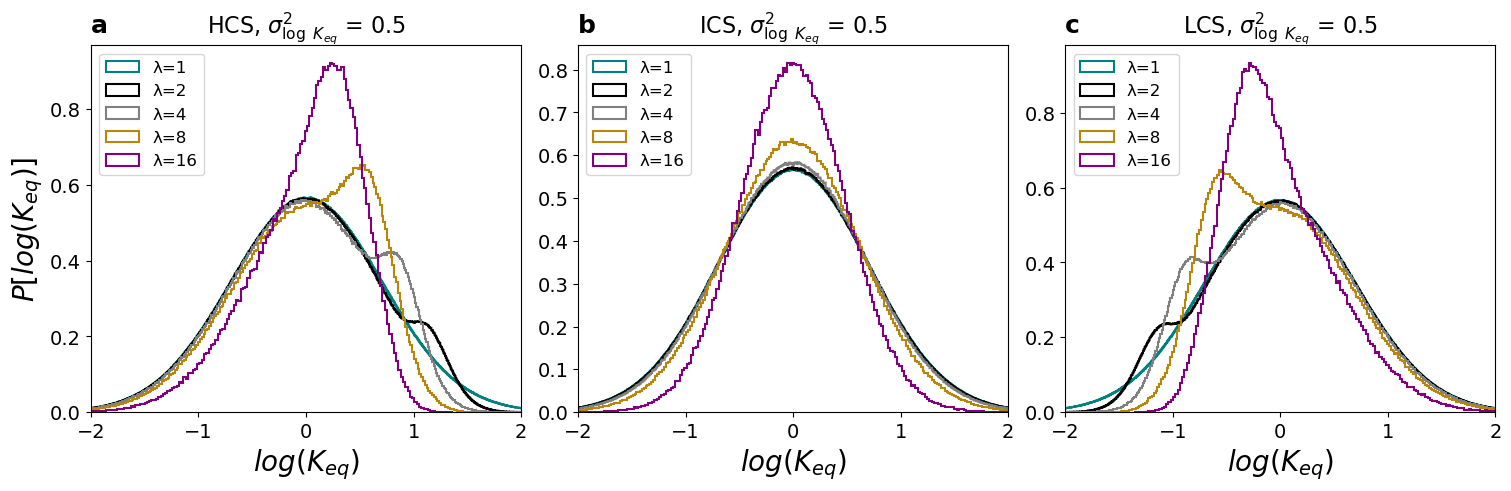

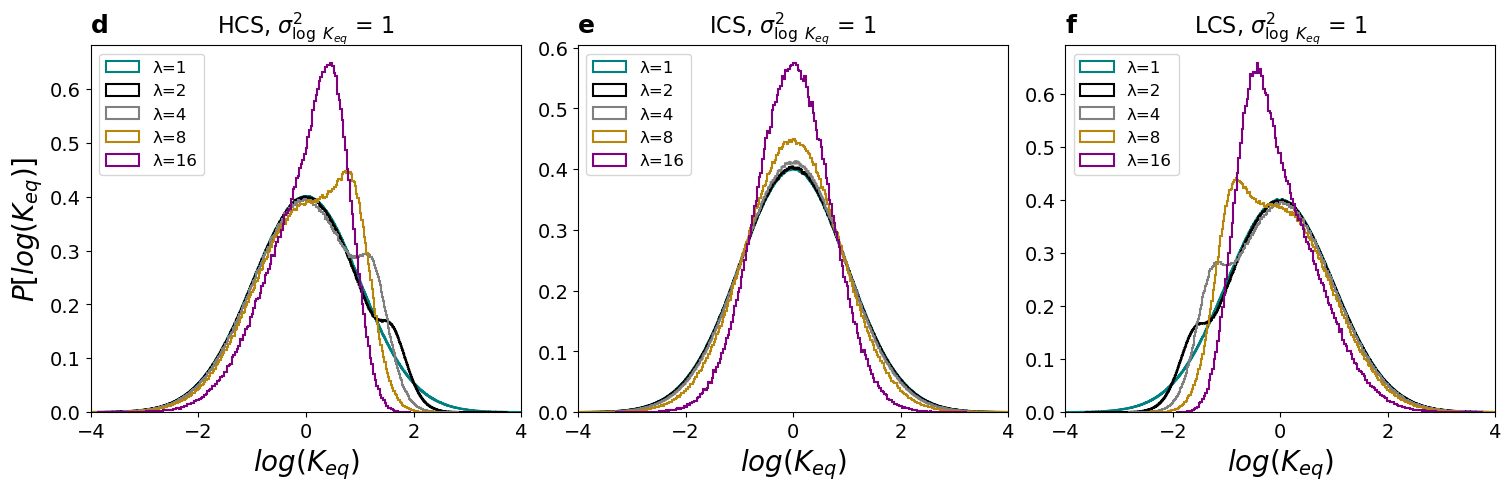

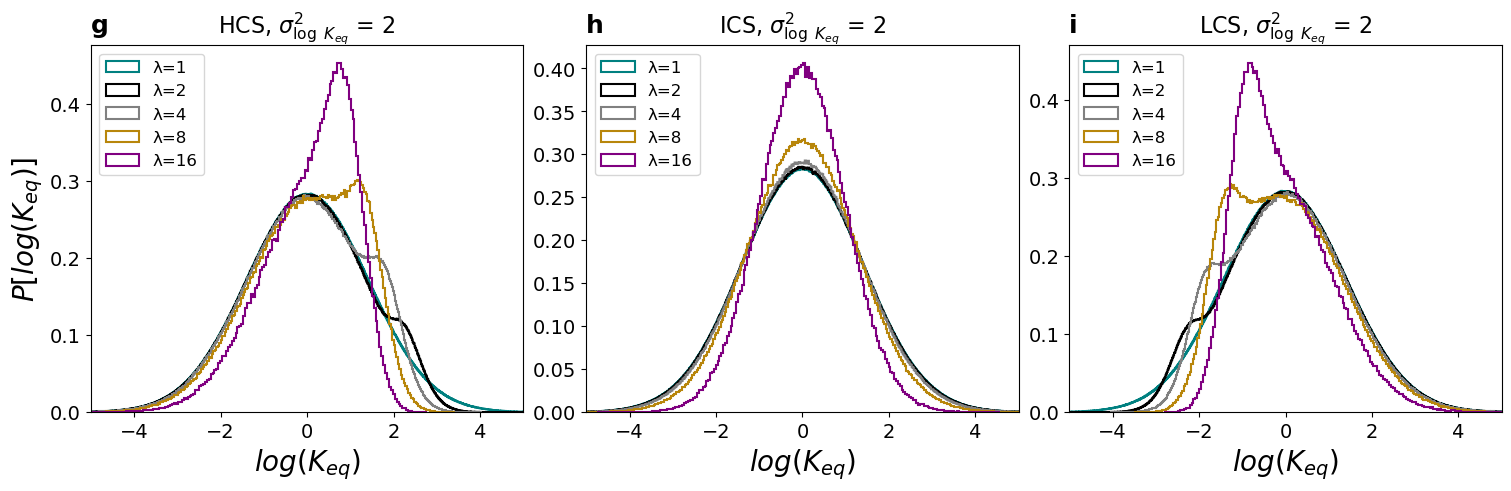

In [73]:
### Probability density function with PDF of log(k(r))####

nseeds = 128

scale_col_FG = ["teal","black","grey","darkgoldenrod","purple", "violet","deepskyblue"]

scalesHist = [1,2,4,8,16]

xTheo = np.linspace(-3, 3, 500)
conDir = ['./2d_1024L_128r/2dcon_128/', './2d_1024L_128r/2dint_128/', './2d_1024L_128r/2ddis_128/']
stCon = ['HCS', 'ICS', 'LCS']
varDir = ['0.5/', '1/', '2/']
varSim = [0.5, 1, 2]
num = [['a','b','c'],['d','e','f'],['g','h','i']]

xlim = ([-2,2], [-4,4], [-5,5])
#xy = [(-1.5,2.3), (-1.5, 2.0), (-1.5, 1.7), (-1.5, 1.4), (-1.5, 1.1)]

for ivar in range(len(varDir)):
    fig, ax = plt.subplots(1, 3, sharey=False, layout='constrained')
    fig.set_figwidth(15)
    rdir2 = varDir[ivar]
    for icon in range(len(conDir)):
        rdir1 = conDir[icon]
        for iscale in range(len(scalesHist)):
            scale = scalesHist[iscale]
            keff = np.array([])
            for iseed in range(nseeds):
                if scale == 1:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/k.npy').reshape(-1)
                    keff = np.append(keff, aux)
                else:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scale)+'.npy').reshape(-1)
                    aux = aux[aux>0]
                    aux = aux[~np.isnan(aux)]
                    keff = np.append(keff, aux)

            ax[icon].hist(np.log(keff), bins='scott', density=True, histtype='step', label='\u03BB'+'='+str(scale), linewidth=1.5, 
                color=scale_col_FG[iscale])
            ax[icon].set_title(num[ivar][icon], fontsize=18, loc='left', weight='bold')
            ax[icon].set_title(stCon[icon]+', '+r"$\sigma^2_{\log\ K_{eq}}$"+' = '+str(varSim[ivar]), fontsize=16, loc='center')
            ax[icon].set_xlabel(r'$log(K_{eq})$', fontsize=20)
            ax[0].set_ylabel(r'$P[log(K_{eq})]$', fontsize=20)
            ax[icon].tick_params(axis='both', labelsize=14)
            ax[icon].set_xlim(xlim[ivar])
            ax[icon].legend(fontsize=12, frameon=True, loc='upper left')

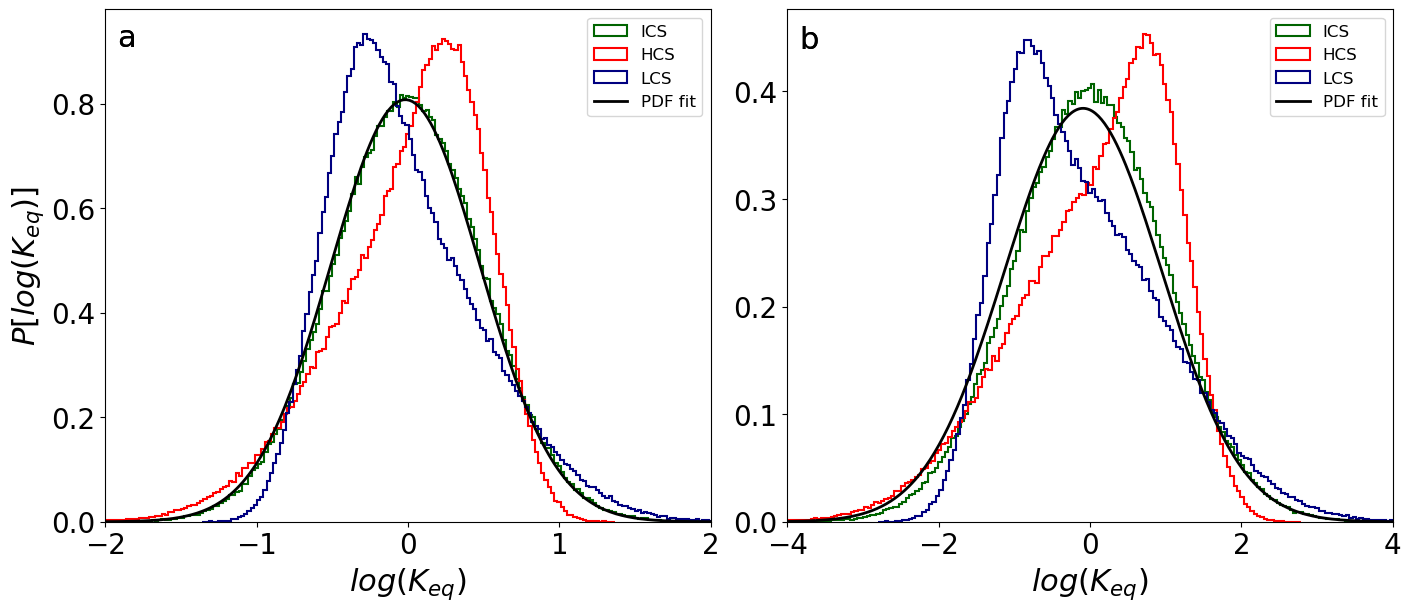

In [45]:
### Probability density function with skewness comparission ####
scalesHist = [32,64,128,256]
xTheo = np.linspace(-5, 5, 500)
scaleGraf = 16


color = ['darkgreen', 'red','navy']
varDir = ['0.5/', '2/']
varSim = [0.5, 2] 

fig, ax = plt.subplots(1, 2, figsize=(14,6), sharey=False, layout='constrained')
#fig.set_figwidth(10)

xlim_sk = ([-2,2], [-4,4])
ylim_sk = ([0,1], [0,0.5])
num = ('a','b', 'c')

for ivar in range(len(varDir)):
    rdir2 = varDir[ivar]
    for icon in range(len(conDir)):
        rdir1 = conDir[icon]
        for iscale in range(len(scalesHist)):
            scale = scalesHist[iscale]
            keff = np.array([])
            for iseed in range(nseeds):
                aux = np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scaleGraf)+'.npy').reshape(-1)
                aux = aux[aux>0]
                aux = aux[~np.isnan(aux)]
                keff = np.append(keff, aux)
           
        ax[ivar].hist(np.log(keff), bins='scott', density=True, histtype='step', label=stCon[icon], linewidth=1.5, color=color[icon])
        #ax[ivar].set_title(stCon[icon]+', '+r"$\sigma^2_{\log\ K_{eq}}$"+' = '+str(varSim[ivar])+', '+'\u03BB'+'='+str(scaleGraf), fontsize=fontsize)
        #ax[ivar].set_title(num[ivar], fontsize=22, loc='left', weight='bold')
        #ax[ivar].set_title(r"$\sigma^2_{\log\ K_{eq}}$"+' = '+str(varSim[ivar]), fontsize=20, loc='center')
        ax[ivar].set_xlabel(r'$log(K_{eq})$', fontsize=22)
        ax[0].set_ylabel(r'$P[log(K_{eq})]$', fontsize=22)
        ax[ivar].tick_params(axis='both', labelsize=20)
        #ax[ivar].set_ylim(0,1)
        #ax[ivar].set_xlim(-4,4)
        ax[ivar].set_xlim(xlim_sk[ivar])
        #ax[ivar].set_ylim(ylim_sk[ivar])
        #ax[ivar].set_yticks([])
        
    PDF = 1/(np.sqrt(2*np.pi*np.var(np.log(keff)))) * np.exp(-(xTheo-np.mean(np.log(keff)))**2/(2*np.var(np.log(keff))))
    ax[ivar].plot(xTheo, PDF, color='black', linewidth=2, label='PDF fit', linestyle='-')
    ax[ivar].legend(fontsize=12)
    ax[0].text(-1.92, 0.91, 'a', style='normal', fontsize=22)
    ax[1].text(-3.85, 0.44, 'b', style='normal', fontsize=22)
    #ax[ivar].text(60, 2.65, num[icon], style='normal', fontsize=18)
    #ax[ivar].legend(fontsize=16, frameon=True)
    #fig.savefig('2D_PDF_skewComp.png', format='png', dpi=300, bbox_inches='tight')

## __Skewness, 3rd gaussian moment__

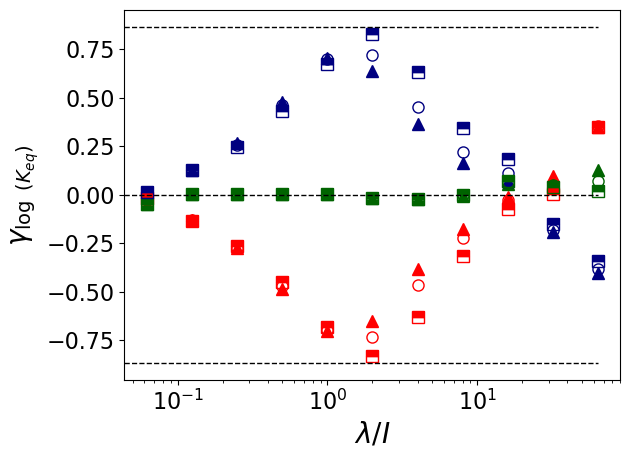

In [68]:
### Skewness ####

from scipy.stats import skew

nseeds = 128
markerfill = ['full', 'none', 'top']
marker_skew = ['^', 'o', 's']

num = ['a', 'b', 'c']

# conDir = ['./2dint/', './2dcon/', './2ddis/']
# varDir = ['0.5/', '1/', '2/'] 
# varSim = [0.5, 1, 2] 

for ivar in range(len(varDir)):
    rdir2 = varDir[ivar]
    for icon in range(len(conDir)):
        rdir1 = conDir[icon]
        skewness = np.zeros(len(scales))
        for iscale in range(len(scales)):
            scale = scales[iscale]
            aux = np.array([])
            for iseed in range(nseeds):
                if scales[iscale] == 1:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/k.npy').reshape(-1)
                elif iscale == len(scales)-1:
                    aux = np.append(aux, np.loadtxt(rdir1+rdir2+str(iseed)+'/SolverRes.txt')[0])
                else:
                    try:
                        aux = np.append(aux, np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scale)+'.npy').reshape(-1))
                        aux = aux[aux>0]
                        aux = aux[~np.isnan(aux)]
                    except:
                        pass
            skewness[iscale] = skew(np.log(aux))
            #print(skewness, skewness.shape)
        plt.semilogx(scales/lc, skewness, color=color[icon], marker=marker_skew[ivar], markersize=8, fillstyle=markerfill[ivar], 
            label=r'$\sigma^2_{Y}$'+' = '+ str(varSim[ivar]), linestyle='none')
        #ax[icon].set_title('Skewness'+', '+stCon[icon], fontsize=fontsize)
        #plt.legend(fontsize=12, frameon=True, loc='best', ncol=3)
        plt.xlabel(r'$\lambda / I$', fontsize=20)
        plt.ylabel(r"$\gamma_{\log\ (K_{eq})}  $",fontsize=20)
        plt.tick_params(axis='both', labelsize=16)
plt.hlines(0, 0, 64, linestyle='--', color='black', linewidth=1)
plt.hlines(-0.865,0 , 64, linestyle='--', color='black', linewidth=1)
plt.hlines(0.865,0 , 64, linestyle='--', color='black', linewidth=1)
plt.close()        
#plt.savefig('2D_skew_128.png', format='png', dpi=300, bbox_inches='tight')

__Fig. 7__: Skewness of P[log(Keq)] as a function of $\lambda$ / l for (a) ICS, (b) HCS and (c) LCS. Input variance: (△, bottom fill)  $\sigma$(Y)=0.5, (⭘, left fill)  $\sigma$(Y)=1 and (◻, right fill)  $\sigma$(Y)=2. It shows a clear collapse for all $\sigma$(Y) for each connectivity structure. The $\gamma$[log(Keq)] values for ECI are close to zero, while for HCS are negatives with a minimum on $\lambda$ / l=1 and for LCS are positives with a maximum on $\lambda$ / l=1.

## __Variance__

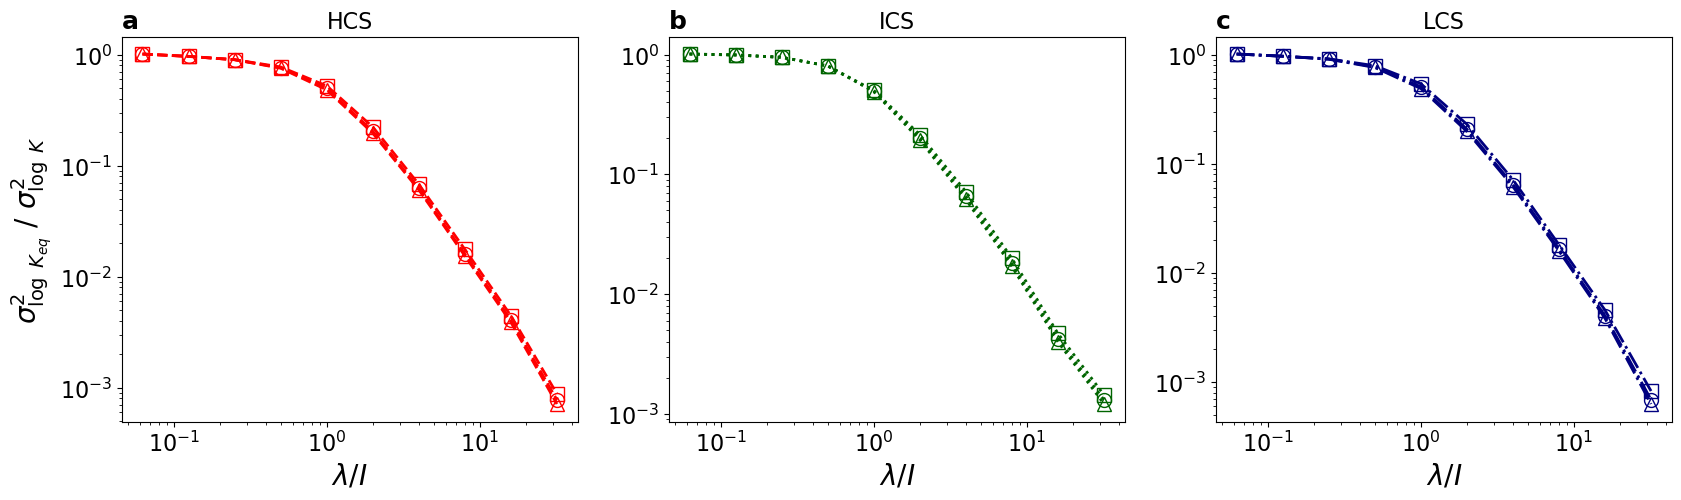

In [3]:
### Variance ###


fix, ax =plt.subplots(1,3, figsize=(20,5))#, layout='constrained')

scales = np.array([1,2,4,8,16,32,64,128,256,512]) 

num=['a', 'b', 'c']

nseeds=10

for ivar in range(len(varDir)):
    rdir2 = varDir[ivar]
    for icon in range(len(conDir)):
        rdir1 = conDir[icon]
        keff = np.zeros(len(scales))
        for iscale in range(len(scales)):
            scale = scales[iscale]
            aux = np.array([])
            for iseed in range(nseeds):
                if scale == 1:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/k.npy').reshape(-1)
                # elif iscale == len(scales)-1:
                #     aux = np.append(aux, np.loadtxt(rdir1+rdir2+str(iseed)+'/SolverRes.txt')[0])
                else:
                    try:
                        aux = np.append(aux, np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scale)+'.npy').reshape(-1))
                        aux = aux[aux>0]
                        aux = aux[~np.isnan(aux)]
                    except:
                        pass
            keff[iscale] = np.nanvar(np.log(aux))
            
        ax[icon].loglog(scales/lc, keff/var_FG[icon][ivar], color=color[icon], marker=marker[ivar], linestyle=linestyle[icon], 
        linewidth=2, markersize=10, fillstyle='none', label=r'$\sigma^2_{Y}$'+' = '+ str(varSim[ivar]))
        #ax[icon].set_title('Variance'+', '+stCon[icon], fontsize=20)
        ax[icon].set_xlabel(r'$\lambda / I$', fontsize=20)
        ax[0].set_ylabel(r"$\sigma^2_{\log\ K_{eq}}\ /\ \sigma^2_{\log\ K}$",fontsize=20)
        ax[icon].tick_params(axis='both', labelsize=16)
        
        ax[icon].set_title(num[icon], fontsize=18, loc='left', weight='bold')
        ax[icon].set_title(stCon[icon], fontsize=16, loc='center')
        #ax[icon].legend(fontsize=14, frameon=True)

## __Normalized variance__

/tmp/ipykernel_10659/2937612910.py:32: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keff[iscale] = np.nanvar(np.log(aux))


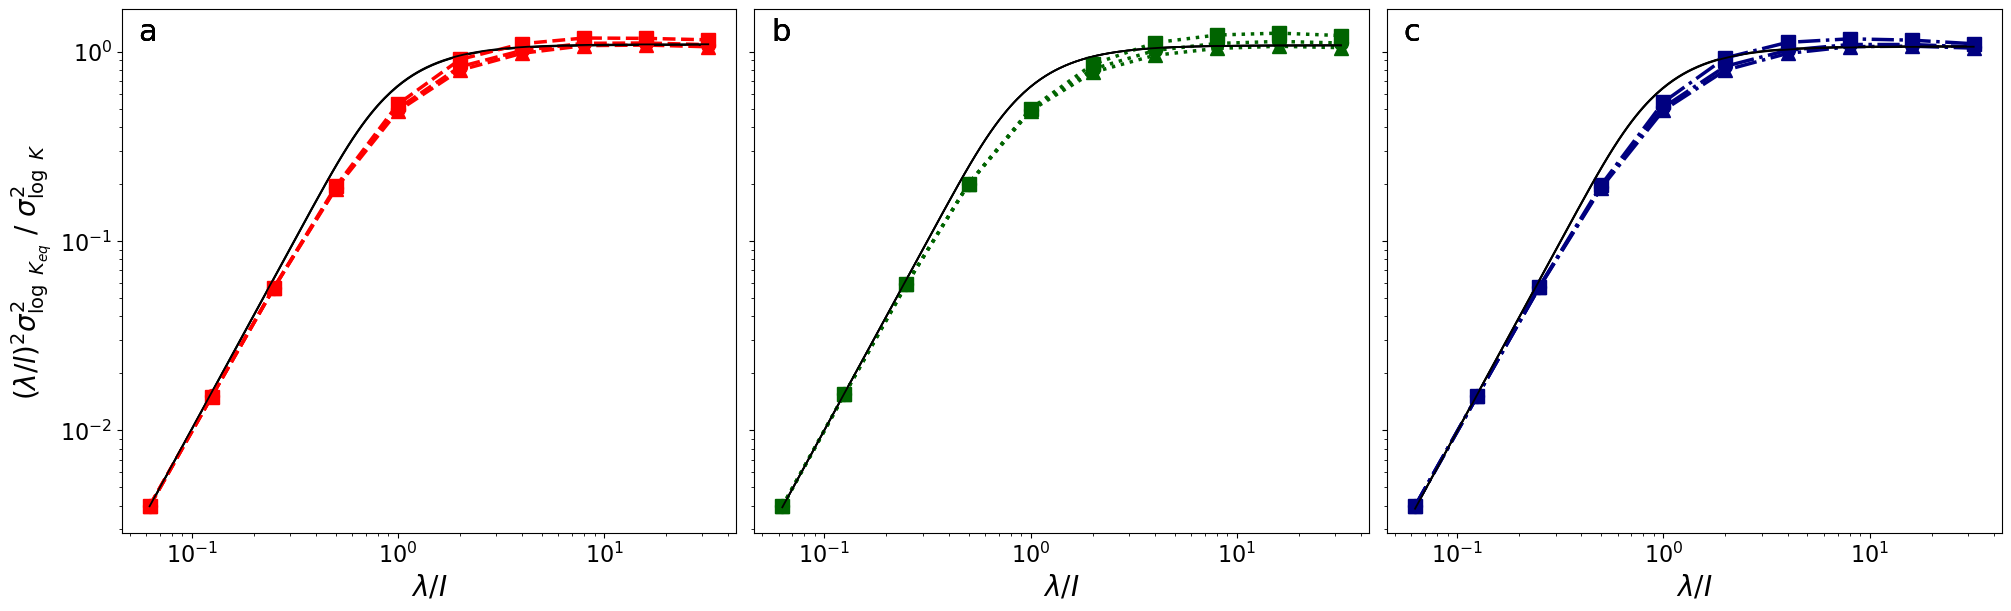

In [12]:
### Normalized Variance ###

fig, ax =plt.subplots(1,3, sharey=True, figsize=(20,6), layout='constrained')

scales = np.array([1,2,4,8,16,32,64,128,256,512,1024]) 
scaleAtt = np.linspace(1,512,1000)

num=['a', 'b', 'c']

nseeds=128

for ivar in range(len(varDir)):
    rdir2 = varDir[ivar]
    for icon in range(len(conDir)):
        rdir1 = conDir[icon]
        keff = np.zeros(len(scales))
        for iscale in range(len(scales)):
            scale = scales[iscale]
            aux = np.array([])
            for iseed in range(nseeds):
                if scale == 1:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/k.npy').reshape(-1)
                # elif iscale == len(scales)-1:
                #     aux = np.append(aux, np.loadtxt(rdir1+rdir2+str(iseed)+'/SolverRes.txt')[0])
                else:
                    try:
                        aux = np.append(aux, np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scale)+'.npy').reshape(-1))
                        aux = aux[aux>0]
                        aux = aux[~np.isnan(aux)]
                    except:
                        pass
            keff[iscale] = np.nanvar(np.log(aux))
            
        ax[icon].loglog(scales/lc, ((scales/lc)**2)*keff/var_FG[icon][ivar], color=color[icon], marker=marker[ivar], linestyle=linestyle[icon], 
        linewidth=2.5, markersize=10, fillstyle='full', label=r'$\sigma^2_{Y}$'+' = '+ str(varSim[ivar]))
        #ax[icon].set_title('Normalized Variance'+', '+stCon[icon], fontsize=20)
        ax[icon].set_xlabel(r'$\lambda / I$', fontsize=20)
        ax[0].set_ylabel(r"$(\lambda / l)^2\sigma^2_{\log\ K_{eq}}\ /\ \sigma^2_{\log\ K}$",fontsize=20)
        ax[icon].tick_params(axis='both', labelsize=16)
        #ax[icon].legend(fontsize=14, frameon=True)
        
        #ax[icon].set_title(num[icon], fontsize=18, loc='left', weight='bold')
        #ax[icon].set_title(stCon[icon], fontsize=16, loc='center')
        
        ax[icon].loglog(scaleAtt/lc, ((scaleAtt/lc)**2)*attinger_var(var_FG[icon][ivar], scaleAtt, 1.3, lc, kg_FG[icon][ivar])/
        var_FG[icon][ivar], label='Analytical', color='black', linewidth=1.3, linestyle='-')
        ax[icon].text(0.055, 1.15, num[icon], style='normal', fontsize=22)
        
   

__Fig. 8a__: $(\lambda /l)^{2}\sigma[log(Keq)]/\sigma (Y)$  as a function of $\lambda$/l for (a) (. . .) HCS, (b) (- - -) ICS and (c)  (- . -) LCS for 2D media samples. Input variance: (△) $\sigma$(Y)=0.5, (〇) $\sigma$(Y)=1 and (◻) $\sigma$(Y)=2. The numerical experiments are compared with (___) analytical results based on Eberhard et al., 2006 equations where D=2 and as=1.3.

### __Collapse of normalized variances__

/tmp/ipykernel_4106/4130411995.py:23: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keff[iscale] = np.nanvar(np.log(aux))


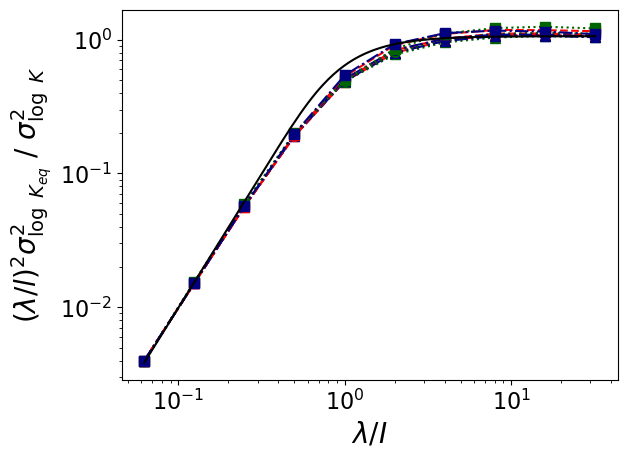

In [71]:
### Variance ###

for ivar in range(len(varDir)):
    rdir2 = varDir[ivar]
    for icon in range(len(conDir)):
        rdir1 = conDir[icon]
        keff = np.zeros(len(scales))
        for iscale in range(len(scales)):
            scale = scales[iscale]
            aux = np.array([])
            for iseed in range(nseeds):
                if scales[iscale] == 1:
                    aux = np.load(rdir1+rdir2+str(iseed)+'/k.npy').reshape(-1)
                # elif iscale == len(scales)-1:
                #     aux = np.append(aux, np.loadtxt(rdir1+rdir2+str(iseed)+'/SolverRes.txt')[0])
                else:
                    try:
                        aux = np.append(aux, np.load(rdir1+rdir2+str(iseed)+'/KpostProcess/Kperm'+str(scale)+'.npy').reshape(-1))
                        aux = aux[aux>0]
                        aux = aux[~np.isnan(aux)]
                    except:
                        pass
            keff[iscale] = np.nanvar(np.log(aux))
            
        plt.loglog(scales/lc, ((scales/lc)**2)*keff/var_FG[icon][ivar], color=color[icon], marker=marker[ivar], linestyle=linestyle[icon], 
        linewidth=1.5, markersize=7, fillstyle='full', label=r'$\sigma^2_{Y}$'+' = '+ str(varSim[ivar]))
        #plt.title('Normalized Variance')
        plt.xlabel(r'$\lambda / I$', fontsize=20)
        plt.ylabel(r"$(\lambda / l)^2\sigma^2_{\log\ K_{eq}}\ /\ \sigma^2_{\log\ K}$",fontsize=20)
        plt.tick_params(axis='both', labelsize=16)
plt.loglog(scaleAtt/lc, ((scaleAtt/lc)**2)*attinger_var(var_FG[icon][ivar], scaleAtt, 1.3, lc, kg_FG[icon][ivar])/
var_FG[icon][ivar], label='Analytical', color='black', linewidth=1.5, linestyle='-')
        #plt.legend(fontsize=14, frameon=True)
#plt.savefig('2D_var.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

__Fig. 8b__:Collapse of normalized variances for (. . .) HCS, (- - -) ICS and (- . -) LCS for all input log conductivity variances: (△) $\sigma$(Y)=0.5, (〇) $\sigma$(Y)=1 and (◻) $\sigma$(Y)=2 compared with (___) analytical results based on Eberhard et al., 2006 equationswhere D=2 and as=1.3.